**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


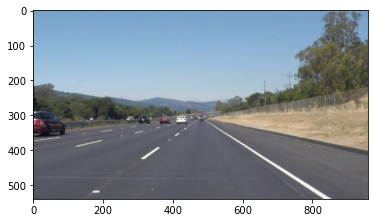

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def detect_outliers(data, threshold=3):
    '''
    Returns the mask of where the outliers are
    @param data: array containing the dataset
    @param threshold: floating point number determining how many standard deviations away from the mean outliers must be
    @return an array with a mask of where all elements outside -threshold*std to +threshold*std
    '''
    mean = np.mean(data)
    std = np.std(data)
    
    # anything outside [-threshold*std, +threshold*std] is an outlier
    outlier_mask = abs((data - mean)/std) > threshold
    
    return outlier_mask


def extend_data(data, weights):
    """
    Each column in data will be repeated according to its weight
    @param data: a NxM array
    @param weights: an 1xM array where each element determines how many times each column must be repeated
    """        
    # making sure the weights are integers, as data can only be repeated an integer number of times
    weights = np.int32(weights)
    # in order to facilitate statistics, this array will extended. Each line will slope, y_offset will be repeated length times 
    extended_data = np.zeros((data.shape[0], weights.sum()))
    i = 0  # iterates over the extended_data array
    for j in range(len(weights)):
        # repeating the j-th column (data[:, j]) weights[j] times and placing it in the section extended_data[:, i:i + weights[j]]
        extended_data[:, i:i + weights[j]] = np.repeat([data[:, j]], weights[j], axis=0).T
        i += weights[j]
    
    return extended_data
    
    
def filter_lines(lines, threshold=3, summary_required=False):
    # an array containing the slopes, line lengths and vertical offsets, one row for each parameter, one column for each line
    lines_data = np.zeros((3, len(lines)))

    # References to the corresponding parameters in the array, for readability
    slopes, y_offsets, lengths = lines_data

    i = 0  # to keep track of the iterations

    for line in lines:
        for x1,y1,x2,y2 in line:
            # being careful with vertical lines
            try:
                slopes[i] = (y2-y1)/(x2-x1)
            except:
                # they won't be used, anyway
                slopes[i] = np.inf
                
            if np.isnan(slopes[i]) or np.isinf(slopes[i]):
                print("Slope", slopes[i], i)
                
            # calculate the vertical offset (y at x=0) of each line
            y_offsets[i] = (y1 - slopes[i] * x1)
            if np.isnan(y_offsets[i]) or np.isinf(y_offsets[i]):
                print("Yoffsset", y_offsets[i], i)
                
            # longer lines have more influence on the mean of the slope of the lane lines
            lengths[i] = np.ceil(np.sqrt((x2-x1)**2 + (y2-y1)**2))
            if np.isnan(lengths[i]) or np.isinf(lengths[i]):
                print("length",lengths[i], i)

        i += 1
        
    min_angle = 25
    max_angle = 80
    
    reasonable_angles_mask = (abs(np.degrees(np.arctan(slopes))) > min_angle) & (abs(np.degrees(np.arctan(slopes))) < max_angle)
    
    # lines whose slope is within -threshold_angle to +threshold_angle deg will be removed, as they are almost horizontal
    right_mask = (slopes > 0) & reasonable_angles_mask
    right_lines = lines[right_mask]
    r_slopes, r_y_offsets, r_lengths = right_lines_data = lines_data[:, right_mask]
    
    # lines with a negative slope are on the left hand side
    left_mask = (slopes < 0) & reasonable_angles_mask
    left_lines = lines[left_mask]
    l_slopes, l_y_offsets, l_lengths = left_lines_data = lines_data[:, left_mask]
    
    try:
        assert not (np.any([np.isnan(r_slopes) | np.isinf(r_slopes)]) or r_slopes.size==0)
    except:
        print("There is a nan value in r_slopes", r_slopes)
        return
                    
    try:
        assert not (np.any([np.isnan(l_slopes) | np.isinf(l_slopes)]) or l_slopes.size==0)
    except:
        print("There is a nan value in l_slopes", l_slopes)
        return
    try:
        assert not (np.any([np.isnan(r_y_offsets) | np.isinf(r_y_offsets)]) or r_y_offsets.size==0)
    except:
        print("There is a nan value in r_y_offsets", r_y_offsets)
        return           
    try:
        assert not (np.any([np.isnan(l_y_offsets) | np.isinf(l_y_offsets)]) or l_y_offsets.size==0)
    except:
        print("There is a nan value in l_y_offsets", l_y_offsets)
        return
    
    # if only the summary is required (final step in drawing lane lines)
    if summary_required:
        # extending the following arrays to facilitate calcualtion of mean and removing outliers
        # leaving the last row of the lines_data arrays, as those do not need be extended
        r_slopes, r_y_offsets = r_full_data = extend_data(right_lines_data[:2], r_lengths)
        l_slopes, l_y_offsets = l_full_data = extend_data(left_lines_data[:2], l_lengths)

        # removing the lines with abnormal slopes and vertical offsets form the lines to be plotted
        r_slopes, r_y_offsets = r_full_data[:, ~(detect_outliers(r_slopes, threshold) & detect_outliers(r_y_offsets, threshold))]
        l_slopes, l_y_offsets = l_full_data[:, ~(detect_outliers(l_slopes, threshold) & detect_outliers(l_y_offsets, threshold))]
        
        return r_slopes.mean(), r_y_offsets.mean(), l_slopes.mean(), l_y_offsets.mean()
    
    # if only the filtered lines are required
    # concatenate the two sets of lines for drawing purposes
    return np.concatenate((right_lines, left_lines))

    
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            

def draw_lanes(img, vertices, lines, color=[255, 0, 0], thickness=5, filter_threshold=3):

    """
    The goal of this function is to, given the image of a road, and lines from the hough transform
    draw only one line per side of the lane.

    @param: region_mask is the part where the lines will be drawn
    """
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    '''
    # This function was modified to account for the many lines with different slopes
    # It will find the weighed average of the slopes of the lane lines

    # an array containing the slopes, line lengths and vertical offsets, one row for each parameter, one column for each line
    lines_data = np.zeros((3, len(lines)))

    # References to the corresponding parameters in the array, for readability
    slopes, lengths, y_offsets = lines_data
    # print("Slopes:", slopes)

    i = 0  # to keep track of the iterations

    for line in lines:
        for x1,y1,x2,y2 in line:
            # being careful with vertical lines
            try:
                slopes[i] = (y2-y1)/(x2-x1)
            except:
                # they won't be used, anyway
                slopes[i] = np.nan

            # longer lines have more influence on the mean of the slope of the lane lines
            lengths[i] = np.ceil(np.sqrt((x2-x1)**2 + (y2-y1)**2))

            # calculate the vertical offset (y at x=0) of each line
            y_offsets[i] = (y1 - slopes[i] * x1)

        i+=1 
    
    
    # in order to facilitate statistics, this array will extended. Each line will slope, y_offset will be repeated length times 
    full_lines_data = np.zeros((2, int(lengths.sum())))
    i = 0  # iterates over the full_lines_data array
    for slope, length, y_offset in lines_data.T:
        length = int(length)
        full_lines_data[:, i:i + length] = [slope,] * length, [y_offset,] * length
        i += length
    
    # There will be two means and medians, one for the right and one for the left
    # the right ones will have a positive slope, while the left ones will have a negative slope
    # remember that y=0 at the top of the image
    
    # References to the corresponding parameters in the array, for readability
    slopes, y_offsets = full_lines_data
    
    right_lines_data = full_lines_data[:, slopes > 0]
    left_lines_data = full_lines_data[:, slopes < 0]

    # just for more readability
    r_slopes, r_y_offsets = right_lines_data
    l_slopes, l_y_offsets = left_lines_data

#     print("Slope selection:\nRight:",right_lines_data.shape, "\nLeft:", left_lines_data.shape)
#     print(r_slopes.shape, l_slopes.shape)
    
    # Need to find outliers (abnormal) lines and remove them, so they do not affect the mean
    # Starting by finding lines with abnormal slopes
#     r_m = np.median(r_slopes)  # right median
#     r_lq = np.percentile(r_slopes, 25)  # right lower quartile
#     r_uq = np.percentile(r_slopes, 75)  # right upper quartile

#     l_m = np.median(l_slopes)  # right median
#     l_lq = np.percentile(l_slopes, 25)  # left lower quartile
#     l_uq= np.percentile(l_slopes, 75)  # left upper quartile

    # print(right_lines_data)
#     print((r_m + 6*(r_uq - r_m) > r_slopes))
    # removing the lines with abnormal slopes
    right_lines_data = right_lines_data[:, (r_slopes < r_m + 2*(r_uq - r_m) ) & (r_slopes > r_m - 2*(r_m - r_lq))]
#     right_lines_data = detect_outliers(right_lines_data)
    left_lines_data = left_lines_data[:, (l_slopes < l_m + 2*(l_uq - l_m)) & (l_slopes > l_m - 2*(l_m - l_lq))]
#     left_lines_data = remove_outliers(left_lines_data) 

    # just for more readability
    r_slopes, r_y_offsets = right_lines_data
    l_slopes, l_y_offsets = left_lines_data
    
#     print(right_lines_data)
    # removing the lines with abnormal offsets

    # The longer a line is, the more it will influence the overall slope and vertical offset
#     r_slope = (r_slopes * r_lengths).sum()/r_lengths.sum()
    r_slope = r_slopes.mean()
#     l_slope = (l_slopes * l_lengths).sum()/l_lengths.sum()
    l_slope = l_slopes.mean()
    
    try:
        assert not (np.any([np.isnan(r_slopes)]))
    except:
        print("There is a nan value in r_slopes")
                    
    try:
        assert not (np.any([np.isnan(l_slopes)]))
    except:
        print("There is a nan value in l_slopes")

#     r_y_offset = (r_y_offsets * r_lengths).sum()/r_lengths.sum()
    r_y_offset = r_y_offsets.mean()
#     l_y_offset = (l_y_offsets * l_lengths).sum()/l_lengths.sum()
    l_y_offset = l_y_offsets.mean()
    '''
    r_slope, r_y_offset, l_slope, l_y_offset = filter_lines(lines, threshold=filter_threshold, summary_required=True)
    # Now that there are two lines, each with its own slope and vertical offset, they need to be drawn on the passed image
    # These lines will be drawn on the whole image, from the bottom to the top
    y1, y2 = 0, img.shape[0]
    
    r_x1 = r_x2 = l_x1 = l_x2 = 0
    
    try:
        r_x1 = int((y1 - r_y_offset)/r_slope)
        r_x2 = int((y2 - r_y_offset)/r_slope)

        l_x1 = int((y1 - l_y_offset)/l_slope)
        l_x2 = int((y2 - l_y_offset)/l_slope) 
    except:
        print('ERROR')
        print("Right\n", r_slope, r_y_offset, "\nLeft\n", l_slope, l_y_offset)
        print("Line points\n", (r_x1, y1), (r_x2, y2))  
    

    # drawing the lines from top to bottom on a black image
    black_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)  # a black image with 3 color channels
    cv2.line(black_image, (r_x1, y1), (r_x2, y2), color, thickness)
    cv2.line(black_image, (l_x1, y1), (l_x2, y2), color, thickness)

    black_image = region_of_interest(black_image, vertices)

    # applying the mask, so the lines are only in the region of interest
    return black_image


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import *
from IPython.display import HTML

In [5]:
import os
# creating an list of images from one of the videos
raw_images = []
# clip1 = np.array(list(VideoFileClip("test_videos/solidYellowLeft.mp4").iter_frames()))
# raw_images = [clip1[30], clip1[55], clip1[180], clip1[288], clip1[205], clip1[675]]

clip3 = np.array(list(VideoFileClip("test_videos/challenge.mp4").iter_frames()))
# raw_images = [clip3[28], clip3[98], clip3[106], clip3[108], clip3[121], clip3[155]]
raw_images = [clip3[97], clip3[110], clip3[155]]

# for image_name in os.listdir("test_images/"):
#     raw_images.append(mpimg.imread("test_images/"+image_name))

# getting the size of the image or video frame
(y_size, x_size, _) = raw_images[0].shape

# for i in range(len(raw_images)):
#     print(cv2.imwrite("problems/image"+str(i)+".jpg", cv2.cvtColor(raw_images[i], cv2.COLOR_RGB2BGR)))
#     pass
    
# print(raw_images[4].shape, raw_images[4])
# plt.imshow(raw_images[4])

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

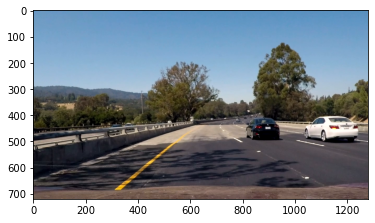

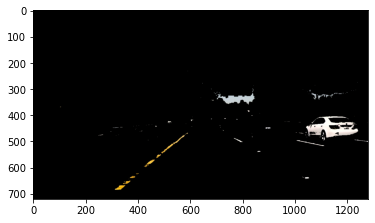

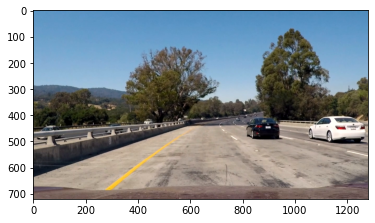

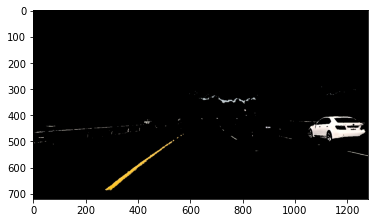

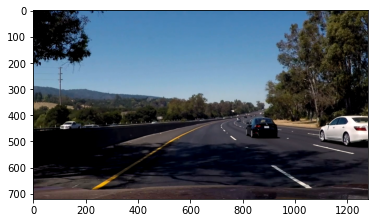

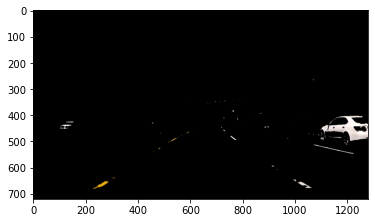

In [78]:
# focus on a particular color (yellow to white, in this case)
def color_focus(image):
    """Keep mostly just yellow and white in the image"""
    yellow_min_hsv = (20, 90, 160)
    yellow_max_hsv = (23, 255, 255)
    white_min_hsv = (0, 0, 200)
    white_max_hsv = (179, 25, 255)
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    yellow_mask = cv2.inRange(hsv_image, yellow_min_hsv, yellow_max_hsv)
    white_mask = cv2.inRange(hsv_image, white_min_hsv, white_max_hsv)
    full_mask = yellow_mask | white_mask
    new_image = cv2.bitwise_and(image, image, mask=full_mask)
    
    return new_image

color_focused = []
# need to convert the image from rgb to hsv, for easy manipulation
# yellow_min_hsv = (18, 0, 0)
# yellow_max_hsv = (25, 255, 255)
# white_min_hsv = (0, 0, 200)
# white_max_hsv = (179, 25, 255)

for i in range(len(raw_images)):
    new_image = color_focus(raw_images[i])
    color_focused.append(new_image)
    plt.figure()
    plt.imshow(raw_images[i])
    plt.figure()
    plt.imshow(new_image)

In [79]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
grayed = []  # a list that will contain the grayed out images

for image in color_focused:
    grayed_image = grayscale(image)
    grayed.append(grayed_image)
#     plt.figure()
#     plt.imshow(grayed_image, cmap='gray')

In [80]:
blurred = []  # a list that will contain the blurred images
# blurring the image to remove uncessary edges
for grayed_image in grayed:
    blured_image = gaussian_blur(grayed_image, 5)
    blurred.append(blured_image)
#     plt.figure()
#     plt.imshow(blured_image, cmap='gray')

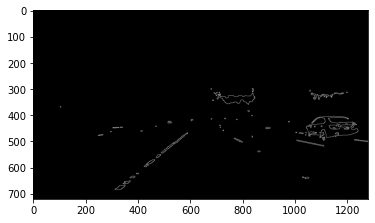

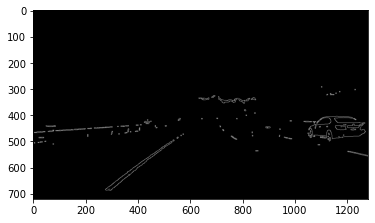

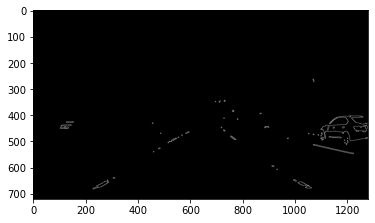

In [81]:
cannyed = []  # a list that will contain the images after teh canny transoform
# detecting the edges on the images and highligting them
for blured_image in blurred:
    cannyed_image = canny(blured_image, 25, 200)
    cannyed.append(cannyed_image)
    plt.figure()
    plt.imshow(cannyed_image, cmap='gray')

In [82]:
# applying a region of interest to the images. Notice how the vertices were made a percentage of the height and width of the image, so this is compatible with any size of the same height:width ratio
vertices = np.array([[(round(0.08*x_size), y_size), (round(0.4*x_size), round(0.65*y_size)), (round(0.65*x_size), round(0.65*y_size)), (round(0.98*x_size), y_size)]])

for image in blurred:
    image = np.dstack((image, image, image))  # stacking the image in 3 so color can be added to it
    highlighted_image = cv2.polylines(image, vertices, isClosed=True, color=(255, 0, 0), thickness=5)
#     plt.figure()
#     plt.imshow(highlighted_image, cmap='gray')


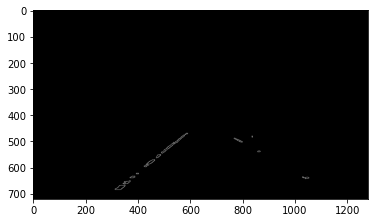

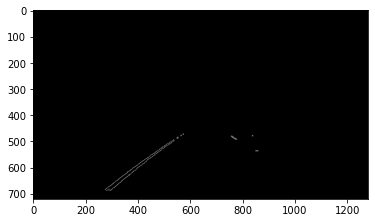

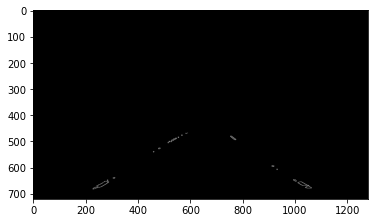

In [83]:
# Now the region of focus can be determined
focused = []
for image in cannyed:
    focused_image = region_of_interest(image, vertices)
    focused.append(focused_image)
    plt.figure()
    plt.imshow(focused_image, cmap='gray')


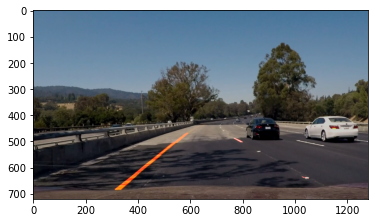

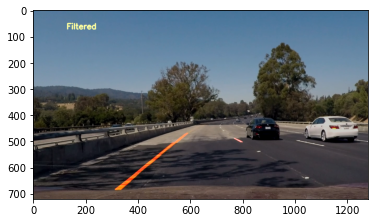

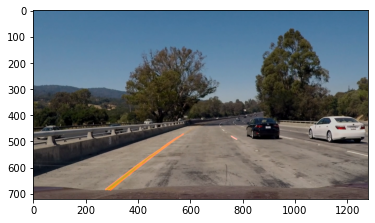

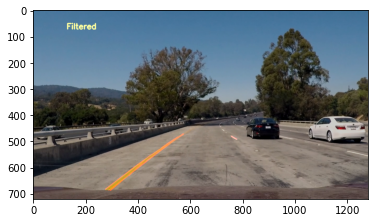

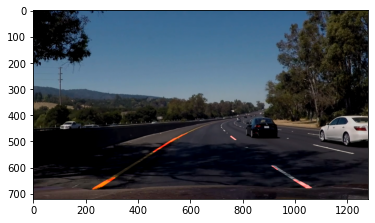

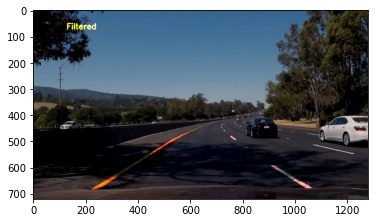

In [84]:
# comparing the lines before and after filtering abnormal lines, just for illustration. Not part of the pipeline
for i in range(len(focused)):
    line_image, lines = hough_lines(focused[i], rho=1, theta=np.radians(0.5), threshold=15, min_line_len=15, max_line_gap=50)
    filtered_lines = filter_lines(lines, threshold=3)
#     print(lines.shape, ":", filtered_lines.shape)
    filtered_lines_image = np.zeros_like(line_image)
    draw_lines(filtered_lines_image, filtered_lines)
    cv2.putText(filtered_lines_image, "Filtered", (round(0.1*x_size), round(0.1*y_size)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 3)

    plt.figure()
    plt.imshow(weighted_img(line_image, raw_images[i]))
    plt.figure()
    plt.imshow(weighted_img(filtered_lines_image, raw_images[i]))
    

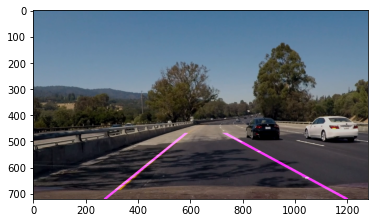

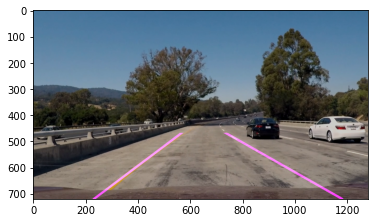

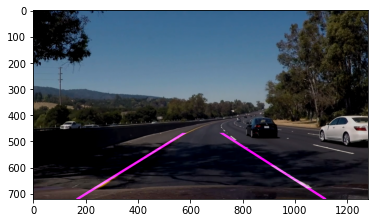

In [85]:
# images_with_lines = []  # a list that will contain the images after the hough transform
marked_lanes = []  # a list of black images with the lanes marked
# lines = None
i = 0
for image in focused:
    lines = cv2.HoughLinesP(image, rho=1, theta=np.radians(0.5), threshold=15, minLineLength=15, maxLineGap=50)
    lane_image = draw_lanes(image, vertices, lines, color=[255,0,255], thickness=8)
#     marked_lanes.append(line_image)

    plt.figure()
    plt.imshow(weighted_img(lane_image, raw_images[i]))
    
    i += 1
   

In [86]:
# combining Hough transformed images with the original ones
# for i in range(len(raw_images)):
#     combined_image = weighted_img(marked_lanes[i], raw_images[i])
#     plt.figure()
#     plt.imshow(combined_image)

# im = np.zeros((20, 20, 3), dtype=np.uint8)
# im[:,:,0:3] = 255,0, 0
# plt.imshow( im)
# print("rgb\n",im)
# print("hsv\n", cv2.cvtColor(im, cv2.COLOR_RGB2HSV))

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [95]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    try:
        y_size, x_size, _ = image.shape

        vertices = np.array([[(round(0.08*x_size), y_size), (round(0.4*x_size), round(0.65*y_size)), (round(0.65*x_size), round(0.65*y_size)), (round(0.98*x_size), y_size)]])

        img = region_of_interest(canny(gaussian_blur(grayscale(color_focus(image)), 5), 50, 200), vertices)
        lines = cv2.HoughLinesP(img, rho=1, theta=np.radians(1), threshold=15, minLineLength=15, maxLineGap=50)
        line_image = draw_lanes(image, vertices, lines, color=[255,0,255], thickness=8, filter_threshold=3)
        result = weighted_img(line_image, image)
        return result
    
    # if there's any error, return a black image
    except e:
        print(e)
        return np.zeros_like(image)

In [96]:
def addFrameN(clip):
    frames = np.array(list(clip.iter_frames()))
    new_clip = np.zeros_like(frames)
    
    i = 0
    for frame in frames:
        cv2.putText(frame, str(i), (round(0.1*x_size), round(0.1*y_size)), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 3)
        new_clip[i] = frame
        i += 1
    return ImageSequenceClip(list(new_clip), fps=clip.fps)

Let's try the one with the solid white lane on the right first ...

In [97]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(2, 3)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip = addFrameN(white_clip)
%time white_clip.write_videofile(white_output, audio=False)

t:   9%|███████████████▋                                                                                                                                                                      | 19/221 [00:00<00:01, 188.62it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 1.45 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [98]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [99]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
yellow_frames = addFrameN(yellow_clip)
%time yellow_frames.write_videofile(yellow_output, audio=False)

t:   3%|█████                                                                                                                                                                                 | 19/681 [00:00<00:03, 184.96it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 4.91 s


In [100]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [101]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = addFrameN(clip3.fl_image(process_image))
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   4%|███████▉                                                                                                                                                                              | 11/251 [00:00<00:02, 107.08it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 3.59 s


In [102]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))